In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
version = '02'

In [29]:
def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)

## Dataset loading

In [13]:
right = pd.read_csv("../data/right.txt", header=None).values.tolist()
left = pd.read_csv("../data/left.txt", header=None).values.tolist()

## Pre-processing

In [14]:
batch_size = 200
batch_right = [right[i:i + batch_size] for i in range(0, len(right), batch_size)]
batch_left = [left[i:i + batch_size] for i in range(0, len(left), batch_size)]

X = np.array(batch_right + batch_left)
y = np.array([0]*len(batch_right) + [1]*len(batch_left))

In [15]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (600, 200, 2)
y shape: (600,)


In [16]:
X_diff = X[:,:-1,:].copy()
X_diff[:,:,0] = np.diff(X[:,:,0])
X_diff[:,:,1] = np.diff(X[:,:,1])

Text(0.5, 0, 'y relative movement (px)')

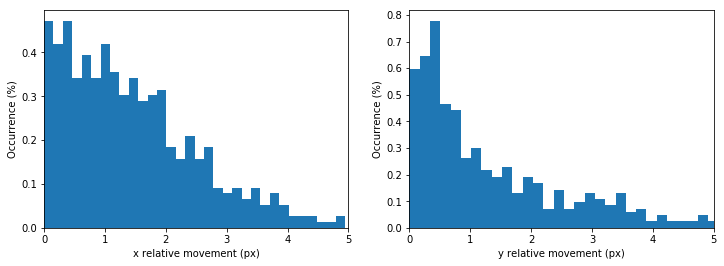

In [17]:
sigma_x = np.std(X_diff[:,:,0], axis=1)
sigma_y = np.std(X_diff[:,:,1], axis=1)
mask = (sigma_x>0.1)*(sigma_y>0.1)

X_filt = X_diff[mask]
y_filt = y[mask]

x_std = 3.398 # np.mean(np.std(X_filt[:,:,0], axis=1))
y_std = 2.926 # np.mean(np.std(X_filt[:,:,1], axis=1))

X_filt[:,:,0] = X_filt[:,:,0] / x_std
X_filt[:,:,1] = X_filt[:,:,1] / y_std

sigma_x_filt = np.std(X_filt[:,:,0], axis=1)
sigma_y_filt = np.std(X_filt[:,:,1], axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 4))
ax1.hist(sigma_x_filt, bins=50, density=True)
ax2.hist(sigma_y_filt, bins=50, density=True)
for ax in (ax1,ax2):
    ax.set_xlim(0,5)
    ax.set_ylabel('Occurrence (%)')
    #ax.set_yticks(np.arange(0,0.41,0.1))
ax1.set_xlabel('x relative movement (px)')
ax2.set_xlabel('y relative movement (px)')

#fig.savefig(f'../plots/relative_movement_hist_corrected.png', bbox_inches='tight')

In [18]:
np.mean(np.std(X_filt[:,:,0], axis=1))

1.4900517595356684

## Training/dev/test set splitting

In [19]:
X = X_filt
y = y_filt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True)
X_dev, X_test, y_dev, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=1, shuffle=True)

## Model definition

In [20]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_dev.shape[1], 2)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


## Model training

In [31]:
adam = Adam(lr=0.0001)
chk = ModelCheckpoint(f'../models/best_model_{version}.pkl', monitor='acc', save_best_only=True, mode='max', verbose=0) #monitor='val_acc'
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history_training = model.fit(X_train, y_train, epochs=200, batch_size=64, callbacks=[chk], validation_data=(X_dev, y_dev))
play_bell()

Train on 345 samples, validate on 172 samples
Epoch 1/200
345/345 [==============================] - 3s 8ms/step - loss: 0.6994 - acc: 0.4899 - val_loss: 0.6998 - val_acc: 0.4535
Epoch 2/200
345/345 [==============================] - 2s 4ms/step - loss: 0.6952 - acc: 0.5101 - val_loss: 0.6951 - val_acc: 0.4767
Epoch 3/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6917 - acc: 0.5246 - val_loss: 0.6909 - val_acc: 0.5116
Epoch 4/200
345/345 [==============================] - 2s 4ms/step - loss: 0.6883 - acc: 0.5275 - val_loss: 0.6878 - val_acc: 0.5116
Epoch 5/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6860 - acc: 0.5391 - val_loss: 0.6850 - val_acc: 0.5116
Epoch 6/200
345/345 [==============================] - 2s 4ms/step - loss: 0.6836 - acc: 0.5275 - val_loss: 0.6826 - val_acc: 0.5058
Epoch 7/200
345/345 [==============================] - 1s 4ms/step - loss: 0.6813 - acc: 0.5304 - val_loss: 0.6803 - val_acc: 0.5116
Epoch 8/200
345/345 [==

Epoch 62/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6028 - acc: 0.6609 - val_loss: 0.5940 - val_acc: 0.6802
Epoch 63/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6111 - acc: 0.6290 - val_loss: 0.5944 - val_acc: 0.7209
Epoch 64/200
345/345 [==============================] - 2s 6ms/step - loss: 0.6019 - acc: 0.6638 - val_loss: 0.5943 - val_acc: 0.7151
Epoch 65/200
345/345 [==============================] - 2s 6ms/step - loss: 0.5965 - acc: 0.6696 - val_loss: 0.5826 - val_acc: 0.7209
Epoch 66/200
345/345 [==============================] - 2s 6ms/step - loss: 0.5989 - acc: 0.6609 - val_loss: 0.5820 - val_acc: 0.6977
Epoch 67/200
345/345 [==============================] - 2s 6ms/step - loss: 0.5877 - acc: 0.6638 - val_loss: 0.5804 - val_acc: 0.7035
Epoch 68/200
345/345 [==============================] - 2s 6ms/step - loss: 0.5862 - acc: 0.6725 - val_loss: 0.5836 - val_acc: 0.6860
Epoch 69/200
345/345 [==============================] - 2s 6ms

Epoch 123/200
345/345 [==============================] - 2s 6ms/step - loss: 0.4011 - acc: 0.8087 - val_loss: 0.3435 - val_acc: 0.8314
Epoch 124/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3851 - acc: 0.8174 - val_loss: 0.3431 - val_acc: 0.8256
Epoch 125/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3778 - acc: 0.8145 - val_loss: 0.3552 - val_acc: 0.7849
Epoch 126/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3753 - acc: 0.7739 - val_loss: 0.3308 - val_acc: 0.8663
Epoch 127/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3656 - acc: 0.8290 - val_loss: 0.3333 - val_acc: 0.8372
Epoch 128/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3632 - acc: 0.8174 - val_loss: 0.3302 - val_acc: 0.8488
Epoch 129/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3628 - acc: 0.8261 - val_loss: 0.3293 - val_acc: 0.8721
Epoch 130/200
345/345 [==============================] 

345/345 [==============================] - 2s 6ms/step - loss: 0.2975 - acc: 0.8522 - val_loss: 0.2646 - val_acc: 0.8837
Epoch 184/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3187 - acc: 0.8203 - val_loss: 0.2696 - val_acc: 0.8314
Epoch 185/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3189 - acc: 0.8232 - val_loss: 0.2851 - val_acc: 0.8547
Epoch 186/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3410 - acc: 0.8319 - val_loss: 0.2796 - val_acc: 0.8721
Epoch 187/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3212 - acc: 0.8406 - val_loss: 0.2611 - val_acc: 0.8721
Epoch 188/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3046 - acc: 0.8406 - val_loss: 0.2760 - val_acc: 0.8721
Epoch 189/200
345/345 [==============================] - 2s 6ms/step - loss: 0.3185 - acc: 0.8261 - val_loss: 0.2670 - val_acc: 0.8779
Epoch 190/200
345/345 [==============================] - 2s 6ms/step 

## Training history plot

Best accuracy on the dev set: 89.5%
Best accuracy on the training set: 85.8%


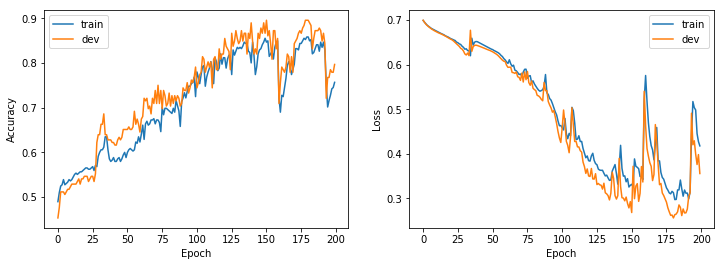

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(history_training.history['acc'], label='train')
ax1.plot(history_training.history['val_acc'], label='dev')

ax2.plot(history_training.history['loss'], label='train')
ax2.plot(history_training.history['val_loss'], label='dev')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.legend()
ax2.legend()

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

best_acc = max(history_training.history['val_acc'])
print(f'Best accuracy on the dev set: {best_acc*100:.1f}%')
best_acc_training = max(history_training.history['acc'])
print(f'Best accuracy on the training set: {best_acc_training*100:.1f}%')
#fig.savefig(f'../plots/model_{version}.png', bbox_inches='tight')

## Evaluation of the model

In [33]:
model = load_model(f'../models/best_model_{version}.pkl') # load best model

In [34]:
dev_preds = model.predict_classes(X_dev)
acc_dev = accuracy_score(y_dev, dev_preds)
print(f'Accuracy on the dev set: {acc_dev*100:.1f}%')

training_preds = model.predict_classes(X_train)
acc_training = accuracy_score(y_train, training_preds)
print(f'Accuracy on the training set: {acc_training*100:.1f}%')

Accuracy on the dev set: 89.5%
Accuracy on the training set: 86.7%


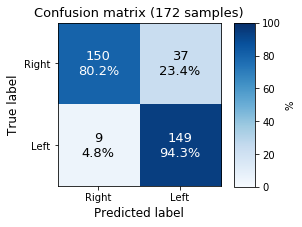

In [40]:
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_dev, dev_preds)
cm = confusion_matrix(y_train, training_preds)

classes=['Right', 'Left']
fig, ax = plt.subplots(1, figsize=(3,3))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

cm_norm = cm / cm.sum(axis=1)*100
im = ax.imshow(cm_norm, cmap='Blues', interpolation='none', clim=(0,100))
ax.set_title(f'Confusion matrix ({y_dev.shape[0]} samples)', size=13)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, f'{cm[i,j]}\n{cm_norm[i, j]:.1f}%', size=13,
             horizontalalignment="center", verticalalignment="center",
             color="white" if cm[i, j] > 60 else "black")
ax.set_ylabel('True label', size=12)
ax.set_xlabel('Predicted label', size=12)

cb_ax = fig.add_axes([0.95, 0.12, 0.1, 0.76])
cb = fig.colorbar(im, cax=cb_ax, orientation='vertical')
cb.set_label('%')

fig.savefig(f'../plots/conf_matrix_{version}.png', bbox_inches='tight')